# Introduction

The objective of this dataset is the classification of various melanoma images in benignant and malignant. 

## Load Libraries & Datasets

In [91]:
# Python Packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
import random
from tqdm import tqdm
import cv2
import albumentations as A
sns.set()

In [2]:
# Custom Packages
import lib.EDA_tools as EDA

In [3]:
input_jpeg_train = 'jpeg/train/'
input_metadata_train = 'train.csv'
input_dcm_train = 'train/'

input_jpeg_test = 'jpeg/test/'
input_metadata_test = 'test.csv'
input_dcm_test = 'test/'

In [4]:
df_md_train = pd.read_csv(input_metadata_train).sort_values(by=['image_name'])
df_md_train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
5,ISIC_0074311,IP_2950485,female,40.0,lower extremity,unknown,benign,0


## Perform initial data analysis

The following conclusions can be drawn from this initial data analysis

#### Insights
- There are some non-null records (>1%). The impact of this will depend on the distribution of the data - if malignant, we might want to keep them, if benignant, might be able to discard them
- The test dataset has less metadata that the train dataset (Train = 7, Test = 4). Hence, features that are not used on test dataset will be discarded

In [5]:
df_md_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33126 entries, 1 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.3+ MB


In [6]:
df_md_train.describe()

,age_approx,target
count,33058.000000,33126.000000
mean,48.870016,0.017630
std,14.380360,0.131603
min,0.000000,0.000000
25%,40.000000,0.000000
50%,50.000000,0.000000
75%,60.000000,0.000000
max,90.000000,1.000000


In [7]:
# Analyse the percentage of missing values of the different features
EDA.perc_missing_vals(df_md_train)

anatom_site_general_challenge    1.590895
age_approx                       0.205277
sex                              0.196220
image_name                       0.000000
patient_id                       0.000000
diagnosis                        0.000000
benign_malignant                 0.000000
target                           0.000000
dtype: float64


In [8]:
df_md_test = pd.read_csv(input_metadata_test).sort_values(by=['image_name'])
df_md_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 514.8+ KB


# Preprocessing
Based on the EDA outcomes, I will now perform the following actions:
- Analyse outliers - Males with 0 years
- Analyse missing records - Determine whether we can handle the missing records or they should be eliminated
- Eliminate duplicated records - As stated by Kaggle competition organisers 

## Outliers


In [9]:
Age_ValidRange = [5, 95]
Age_OutliersMask = (df_md_train.age_approx <= Age_ValidRange[0]) | (df_md_train.age_approx >= Age_ValidRange[1])
Age_Outliers_train = df_md_train.loc[Age_OutliersMask]
Age_Outliers_train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
9647,ISIC_2988939,IP_1300691,male,0.0,torso,unknown,benign,0
22645,ISIC_6872638,IP_1300691,male,0.0,torso,unknown,benign,0


There seem to be one single patient with 0.0 age. Let's see if we can repair this record with additional information on the dataset.

In [10]:
Outlier_ID = 'IP_1300691'
print(df_md_train.loc[df_md_train.patient_id == Outlier_ID])

         image_name  patient_id   sex  age_approx  \
3019   ISIC_1005683  IP_1300691  male        10.0   
9647   ISIC_2988939  IP_1300691  male         0.0   
22645  ISIC_6872638  IP_1300691  male         0.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  
3019                          torso   unknown           benign       0  
9647                          torso   unknown           benign       0  
22645                         torso   unknown           benign       0  


There is another record of this exact patient with the right date. I will assume that all pictures are taken in the same age range.

In [11]:
df_md_train.loc[df_md_train.patient_id == Outlier_ID, 'age_approx'] = 10

## Missing Records

From previous analyses, there were some records missing on certain features. I will now explore this in detail.

In [12]:
MissingMask = df_md_train.isnull().any(axis=1)
df_md_train.loc[MissingMask].head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
33,ISIC_0086462,IP_3200260,female,30.0,NaN,unknown,benign,0
38,ISIC_0088137,IP_5205991,NaN,NaN,lower extremity,unknown,benign,0
61,ISIC_0099474,IP_3057277,male,45.0,NaN,unknown,benign,0
188,ISIC_0174903,IP_2760044,male,40.0,NaN,unknown,benign,0
200,ISIC_0178744,IP_4248414,male,25.0,NaN,unknown,benign,0


In the case of a NaN in sex or age_approx, I will identify whether there are more records with the same patient Id.
- If present, substitute
- If absent, remove record

For NaN records on the melanoma location, I will check whether they are benign or malignant. If benign (majority class by a large margin), I will ignore them for now.

In [13]:
AgeSexMissing_UniqueIDs = df_md_train.loc[df_md_train.loc[:, ["age_approx","sex"]].isnull().any(axis=1)].patient_id.unique()

for id in AgeSexMissing_UniqueIDs:
    print(df_md_train.loc[df_md_train.patient_id == id, ['age_approx', 'sex']])

       age_approx  sex
38            NaN  NaN
384           NaN  NaN
1687          NaN  NaN
3189          NaN  NaN
3615          NaN  NaN
3868          NaN  NaN
4043          NaN  NaN
4718          NaN  NaN
4859          NaN  NaN
6212          NaN  NaN
6856          NaN  NaN
6884          NaN  NaN
7456          NaN  NaN
8123          NaN  NaN
8163          NaN  NaN
8762          NaN  NaN
8957          NaN  NaN
9501          NaN  NaN
10121         NaN  NaN
10432         NaN  NaN
10867         NaN  NaN
11963         NaN  NaN
12052         NaN  NaN
12151         NaN  NaN
13092         NaN  NaN
13394         NaN  NaN
13701         NaN  NaN
14895         NaN  NaN
14986         NaN  NaN
17408         NaN  NaN
17521         NaN  NaN
18101         NaN  NaN
18968         NaN  NaN
19924         NaN  NaN
22425         NaN  NaN
23509         NaN  NaN
23849         NaN  NaN
24826         NaN  NaN
25163         NaN  NaN
25511         NaN  NaN
26776         NaN  NaN
27186         NaN  NaN
28071      

In [14]:
# Unfortunately no records can be recovered, hence eliminate records
DropNA_index = df_md_train.loc[df_md_train.loc[:, ["age_approx","sex"]].isnull().any(axis=1)].index
df_md_train.drop(index = DropNA_index, axis=0, inplace=True)
df_md_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33058 entries, 1 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33058 non-null  object 
 1   patient_id                     33058 non-null  object 
 2   sex                            33058 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32531 non-null  object 
 5   diagnosis                      33058 non-null  object 
 6   benign_malignant               33058 non-null  object 
 7   target                         33058 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.3+ MB


In [15]:
MissingMask = df_md_train.anatom_site_general_challenge.isnull()
df_md_train.loc[MissingMask, 'benign_malignant'].value_counts()

benign       518
malignant      9
Name: benign_malignant, dtype: int64

Unfortunatelly, there seem to be 9 malignant missing values - a class clearly underrepresented.

In [16]:
MissingMask = df_md_train.anatom_site_general_challenge.isnull()
df_md_train.loc[MissingMask].loc[df_md_train.benign_malignant == 'malignant'].head(10)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
6714,ISIC_2105563,IP_1264754,female,65.0,NaN,melanoma,malignant,1
7816,ISIC_2437633,IP_2789041,male,65.0,NaN,melanoma,malignant,1
10149,ISIC_3144222,IP_4615697,male,80.0,NaN,melanoma,malignant,1
11956,ISIC_3684488,IP_7375528,female,55.0,NaN,melanoma,malignant,1
16611,ISIC_5084113,IP_9418573,male,60.0,NaN,melanoma,malignant,1
22090,ISIC_6688417,IP_0961415,male,45.0,NaN,melanoma,malignant,1
22394,ISIC_6786198,IP_5086592,male,55.0,NaN,melanoma,malignant,1
27692,ISIC_8379956,IP_8412988,female,70.0,NaN,melanoma,malignant,1
29305,ISIC_8859274,IP_4615697,male,80.0,NaN,melanoma,malignant,1


As it is unclear whether this feature will be included in the final analysis, I will revisit this later. 

## Duplicated Records

Following the competition guidelines, some records are duplicated - as specified in the attached file. These records will be not considered for post-processing

In [175]:
df_md_dup = pd.read_csv('resources/2020_Challenge_duplicates.csv')

In [176]:
# Remove duplicates on the train set
df_md_train.drop(df_md_train.loc[df_md_train.image_name.isin(df_md_dup.ISIC_id_paired)].index, inplace=True)

In [177]:
# Remove duplicated on the test set
df_md_test.drop(df_md_test.loc[df_md_test.image_name.isin(df_md_dup.ISIC_id_paired)].index, inplace=True)

# Feature and label analysis

## Label - Benign / Malignant

I will look at the distribution of data on the training dataset of the label, understanding its distribution.

#### Insights
- The dataset is highly skewed towards benign samples (> 98% benign)
- No label is missing

In [178]:
# Percentage of data records - over 98.23% of records are benign
df_md_train.benign_malignant.value_counts(normalize=True) * 100

benign       98.220902
malignant     1.779098
Name: benign_malignant, dtype: float64

In [179]:
# No missing label
df_md_train.benign_malignant.isna().sum()

0

## Feature - Patient IDs

I will look at whether we have unique patient IDs per picture, and how many pictures do we have per person.

### Insights
- Most patients have between 1 and 20 pictures
- Over 45 pictures per person can be considered an outlier
- Train and test sets maintain similar distributions
- Test set contain one outlier with almost 250 pictures. This represents over 2% of the total number of records.
- There is no overlap between datasets - train and test don't share patients
- There are a couple of people which are 0 years old - Need to remove them!

In [180]:
# Number of images per patient - Train dataset
pics_per_patient_train = df_md_train.patient_id.value_counts()

In [23]:
# Number of images per patient - Test dataset
pics_per_patient_test = df_md_test.patient_id.value_counts()

Let's plot the distribution of pictures per patient

<AxesSubplot:>

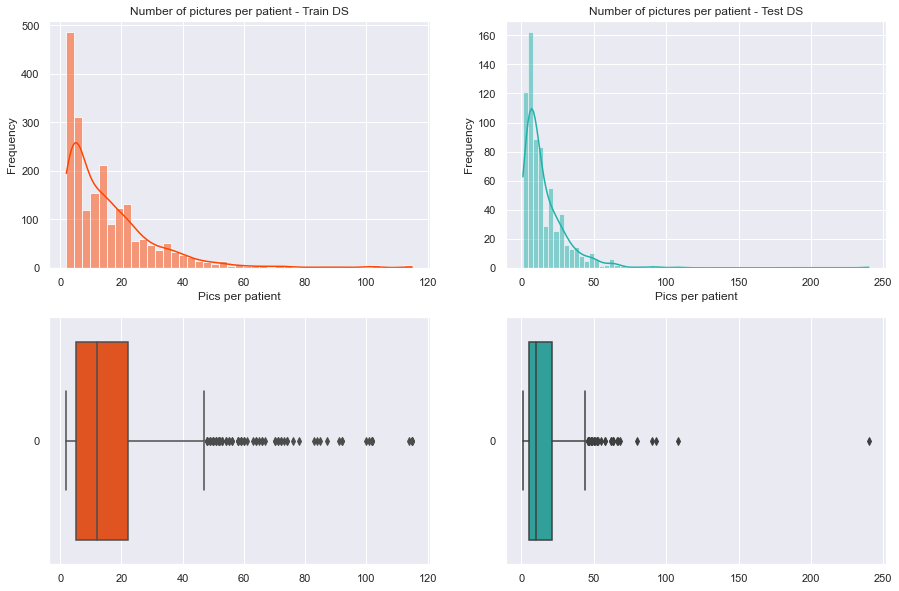

In [24]:
fig, axs = plt.subplots(2,2, figsize=(15,10))

sns.histplot(data=pics_per_patient_train, ax=axs[0, 0], color="orangered", kde=True)
axs[0,0].set_xlabel("Pics per patient")
axs[0,0].set_ylabel("Frequency")
axs[0,0].set_title("Number of pictures per patient - Train DS")

sns.histplot(data=pics_per_patient_test, ax=axs[0, 1], color="lightseagreen", kde=True)
axs[0,1].set_xlabel("Pics per patient")
axs[0,1].set_ylabel("Frequency")
axs[0,1].set_title("Number of pictures per patient - Test DS")

sns.boxplot(data=pics_per_patient_train, ax=axs[1,0], color="orangered", orient='h')
sns.boxplot(data=pics_per_patient_test, ax=axs[1,1], color="lightseagreen", orient='h')

In [25]:
print("95% Quantile - Train Dataset - " + str(np.quantile(pics_per_patient_train, 0.95)))
print("95% Quantile - Test Dataset - " + str(np.quantile(pics_per_patient_test, 0.95)))

95% Quantile - Train Dataset - 43.399999999999864
95% Quantile - Test Dataset - 46.0


In [26]:
train_patient_ids = set(df_md_train.patient_id)
test_patient_ids = set(df_md_test.patient_id.unique())

# Obtain overlap between patient ids between train and test
train_patient_ids.intersection(test_patient_ids)

set()

## Feature - Age

For this feature, we would like to know:
- Is the age correlated with the label?
- How is the distribution of ages? Is there too many samples of one age group?
- Is there a correlation with other variables i.e. Sex?

#### Insights
- Feature sampling follows normal distribution
- Both train and test set follows similar distribution
- There is a correlation between age and melanoma type, as the histogram distribution is shifted towards higher ages. 
- If we correlate Age with Sex, we can see that there is a excess of males over women on higher ages

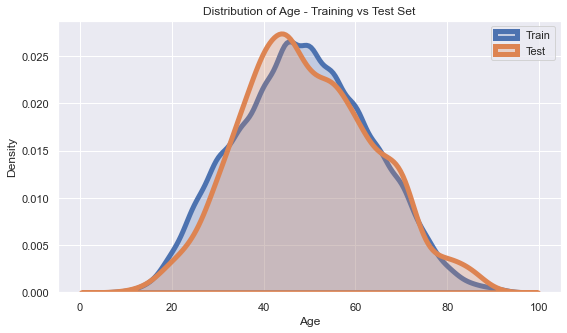

In [27]:
fig = plt.figure(figsize=(9,5))
sns.kdeplot(data=df_md_train, x='age_approx', bw_adjust=1.45, fill=True, linewidth = 5)
sns.kdeplot(data=df_md_test, x='age_approx', bw_adjust=1.45, fill=True, linewidth = 5)
plt.title("Distribution of Age - Training vs Test Set")
plt.xlabel("Age")
plt.legend(['Train', 'Test'])


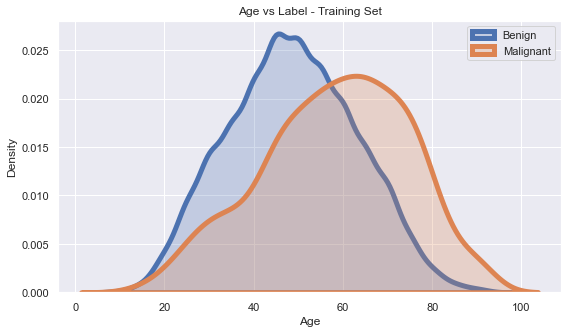

In [28]:
fig = plt.figure(figsize=(9,5))
sns.kdeplot(data=df_md_train[df_md_train.benign_malignant == 'benign'], x='age_approx', bw_adjust=1.45, fill=True, linewidth = 5)
sns.kdeplot(data=df_md_train[df_md_train.benign_malignant == 'malignant'], x='age_approx', fill=True, linewidth = 5)
plt.title("Age vs Label - Training Set")
plt.xlabel("Age")
plt.legend(['Benign','Malignant'])


Text(0.5, 0, 'Age')

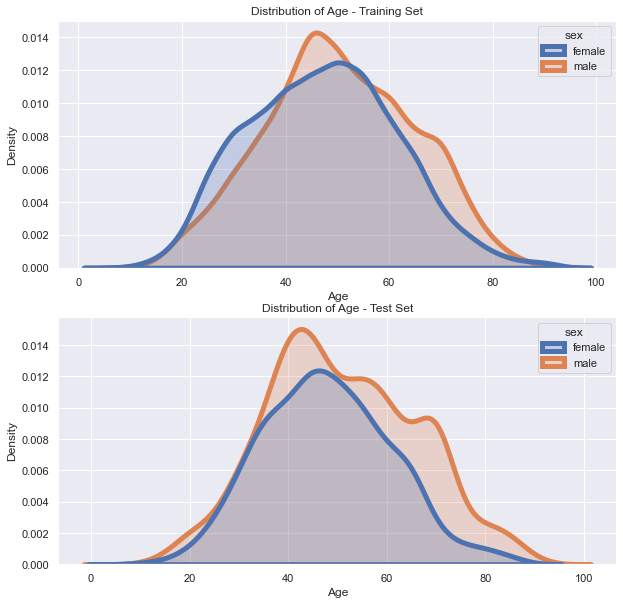

In [29]:
fig, axs = plt.subplots(2,1,figsize=(10,10))
sns.kdeplot(data=df_md_train.sort_values('sex'), x='age_approx', hue='sex',bw_adjust= 1.45, ax=axs[0], fill=True, linewidth = 5)
axs[0].set_title("Distribution of Age - Training Set")
axs[0].set_xlabel("Age")

sns.kdeplot(data=df_md_test.sort_values('sex'), x='age_approx', hue='sex',bw_adjust= 1.45, ax=axs[1], fill=True, linewidth = 5)
axs[1].set_title("Distribution of Age - Test Set")
axs[1].set_xlabel("Age")

## Feature - Sex

For this feature, we would like to know:
- Is there any bias on our sampling in terms of sex?
- Does sex influence on the label?

#### Insights
- There are more males in both test and train data
- This difference is greater in the test data
- The proportion of males with malignant melanoma is slightly higher than females. 
- The prevalecence of malignant melanoma is skewed towards males - this means, benign melanoma is split 50/50 male/female, but in malignant melanoma this proportion jumps to 62/38 male/female 
- However, these phenomena can be either an artifact from our sample (i.e. higher proportion of males in their 70s), or an actual phenomena that needs to be taken into consideration

Text(0.5, 1.0, 'Test Set')

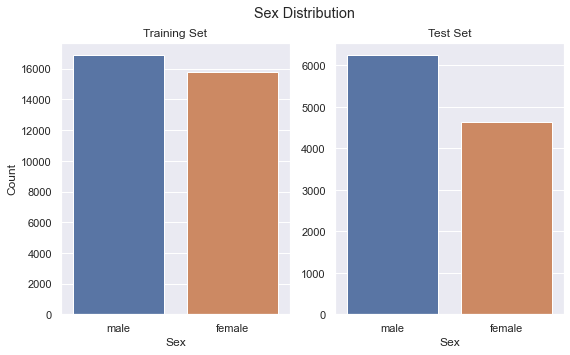

In [30]:
fig, axs = plt.subplots(1,2, figsize=(9,5))
fig.suptitle("Sex Distribution")

sns.countplot(data=df_md_train.sort_values("sex", ascending=False), x='sex', ax=axs[0])
axs[0].set_xlabel("Sex")
axs[0].set_ylabel("Count")
axs[0].set_title("Training Set")

sns.countplot(data=df_md_test.sort_values("sex", ascending=False), x='sex', ax=axs[1])
axs[1].set_xlabel("Sex")
axs[1].set_ylabel("")
axs[1].set_title("Test Set")

Text(0.5, 1.0, '# of Malignant Samples')

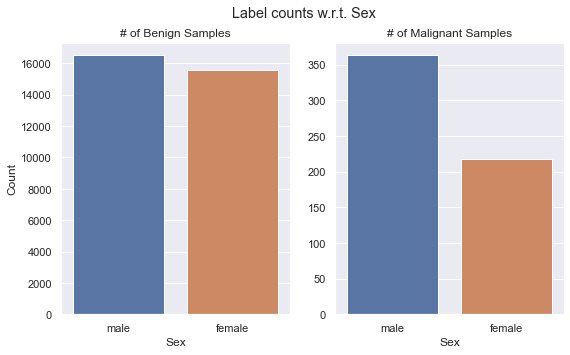

In [31]:
fig, axs = plt.subplots(1,2,figsize=(9,5))
fig.suptitle("Label counts w.r.t. Sex")

sns.countplot(data=df_md_train[df_md_train.benign_malignant == 'benign'].sort_values("sex", ascending=False), x='sex', ax=axs[0])
axs[0].set_xlabel("Sex")
axs[0].set_ylabel("Count")
axs[0].set_title("# of Benign Samples")

sns.countplot(data=df_md_train[df_md_train.benign_malignant == 'malignant'].sort_values("sex", ascending=False), x='sex', ax=axs[1])
axs[1].set_xlabel("Sex")
axs[1].set_ylabel("")
axs[1].set_title("# of Malignant Samples")


In [32]:
Sex_Prop = pd.DataFrame()
Sex_Prop['total'] = df_md_train.groupby('sex')['benign_malignant'].count()
Sex_Prop['benign'] = df_md_train[df_md_train.benign_malignant == 'benign'].groupby('sex')['benign_malignant'].count()
Sex_Prop['malignant'] = df_md_train[df_md_train.benign_malignant == 'malignant'].groupby('sex')['benign_malignant'].count()
Sex_Prop['prop_benign'] = Sex_Prop['benign'] / Sex_Prop['total']
Sex_Prop['prop_malignant'] = Sex_Prop['malignant'] / Sex_Prop['total']
Sex_Prop['sex'] = Sex_Prop.index
Sex_Prop.head()

,total,benign,malignant,prop_benign,prop_malignant,sex
sex,,,,,,
female,15788,15570,218,0.986192,0.013808,female
male,16869,16506,363,0.978481,0.021519,male


Text(0.5, 1.0, 'Proportion of Benign/Malignant Melanoma vs Sex')

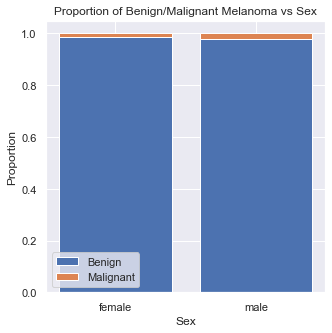

In [33]:
plt.figure(figsize=(5,5))
plt.bar(Sex_Prop.sex, Sex_Prop.prop_benign)
plt.bar(Sex_Prop.sex, Sex_Prop.prop_malignant, bottom=Sex_Prop.prop_benign)
plt.legend(["Benign","Malignant"])
plt.xlabel("Sex")
plt.ylabel("Proportion")
plt.title("Proportion of Benign/Malignant Melanoma vs Sex")

In [34]:
Sex_Prop = pd.DataFrame()
Sex_Prop['total'] = df_md_train.groupby('benign_malignant')['sex'].count()
Sex_Prop['male'] = df_md_train[df_md_train.sex == 'male'].groupby('benign_malignant')['sex'].count()
Sex_Prop['female'] = df_md_train[df_md_train.sex == 'female'].groupby('benign_malignant')['sex'].count()
Sex_Prop['prop_male'] = Sex_Prop['male'] / Sex_Prop['total']
Sex_Prop['prop_female'] = Sex_Prop['female'] / Sex_Prop['total']
Sex_Prop['outcome'] = Sex_Prop.index
Sex_Prop.head()

,total,male,female,prop_male,prop_female,outcome
benign_malignant,,,,,,
benign,32076,16506,15570,0.514590,0.485410,benign
malignant,581,363,218,0.624785,0.375215,malignant


Text(0.5, 1.0, 'Prevalence of Melanoma vs Sex')

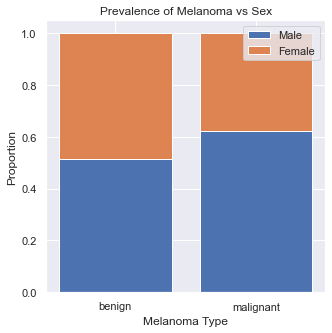

In [35]:
plt.figure(figsize=(5,5))
plt.bar(Sex_Prop.outcome, Sex_Prop.prop_male)
plt.bar(Sex_Prop.outcome, Sex_Prop.prop_female, bottom=Sex_Prop.prop_male)
plt.legend(["Male","Female"])
plt.xlabel("Melanoma Type")
plt.ylabel("Proportion")
plt.title("Prevalence of Melanoma vs Sex")

## Feature - Placement

For this feature, we would like to know:
- What is the distribution of locations?
- Does the proportion of malignant melanomas increase in certain locations?


#### Insights
- The distribution between the train and test set are similar
- The percentage of malignant is slightly higher (+2%) in torso and oral/genial. However, the small sample of the later make this claim weak. 

Text(0.5, 1.0, 'Test Set')

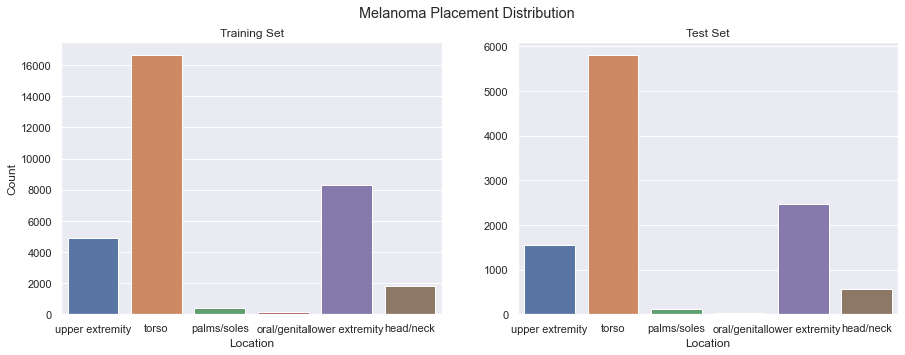

In [36]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("Melanoma Placement Distribution")

sns.countplot(data=df_md_train.sort_values("anatom_site_general_challenge", ascending=False), x='anatom_site_general_challenge', ax=axs[0])
axs[0].set_xlabel("Location")
axs[0].set_ylabel("Count")
axs[0].set_title("Training Set")

sns.countplot(data=df_md_test.sort_values("anatom_site_general_challenge", ascending=False), x='anatom_site_general_challenge', ax=axs[1])
axs[1].set_xlabel("Location")
axs[1].set_ylabel("")
axs[1].set_title("Test Set")


In [37]:
Cat_Prop = pd.DataFrame()
Cat_Prop['total'] = df_md_train.groupby('anatom_site_general_challenge')['benign_malignant'].count()
Cat_Prop['benign'] = df_md_train[df_md_train.benign_malignant == 'benign'].groupby('anatom_site_general_challenge')['benign_malignant'].count()
Cat_Prop['malignant'] = df_md_train[df_md_train.benign_malignant == 'malignant'].groupby('anatom_site_general_challenge')['benign_malignant'].count()
Cat_Prop['prop_benign'] = Cat_Prop['benign'] / Cat_Prop['total']
Cat_Prop['prop_malignant'] = Cat_Prop['malignant'] / Cat_Prop['total']
Cat_Prop['Location'] = Cat_Prop.index
Cat_Prop.head()

,total,benign,malignant,prop_benign,prop_malignant,Location
anatom_site_general_challenge,,,,,,
head/neck,1809,1735,74,0.959093,0.040907,head/neck
lower extremity,8308,8185,123,0.985195,0.014805,lower extremity
oral/genital,124,120,4,0.967742,0.032258,oral/genital
palms/soles,375,370,5,0.986667,0.013333,palms/soles
torso,16620,16363,257,0.984537,0.015463,torso


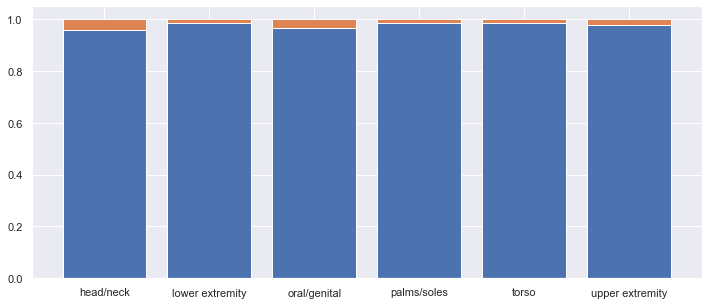

In [38]:
EDA.CumPerc_BarPlot(Cat_Prop.Location, Cat_Prop.prop_benign, Cat_Prop.prop_malignant)

## Feature - Images

I will start by exploring the images, as well as their colour distribution.

In [39]:
DCM_FileList = os.listdir(input_dcm_train)
img_data = pydicom.read_file(input_dcm_train + os.sep + DCM_FileList[0])
print(img_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 220
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.5962.99.1.7207.1260.1589858690868.1.1.0.0.0
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.5962.99.2
(0002, 0013) Implementation Version Name         SH: 'PIXELMEDJAVA001'
(0002, 0016) Source Application Entity Title     AE: 'OURAETITLE'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.5962.99.3
(0008, 0016) SOP Class UID                       UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0008, 0018) SOP Instance UID                    UI: 

In [40]:
def PlotRandomImages(ListImages, path):
    random_images = [np.random.choice(ListImages+'.jpg') for i in range(9)]
    fig, axs = plt.subplots(3,2, figsize=(10,10))
    
    for i in range(3):
        plt.subplot(3,2,2*i+1)
        img = plt.imread(os.path.join(path, random_images[i]))
        plt.imshow(img, cmap='gray')
        plt.axis('off')

        plt.subplot(3,2,2*i+2)
        _ = plt.hist(img[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.05)
        _ = plt.hist(img[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.05)
        _ = plt.hist(img[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.05)
        _ = plt.xlabel('Intensity Value')
        _ = plt.ylabel('Count')
        _ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
    
    # Adjust subplot parameters to give specified padding
    plt.tight_layout()


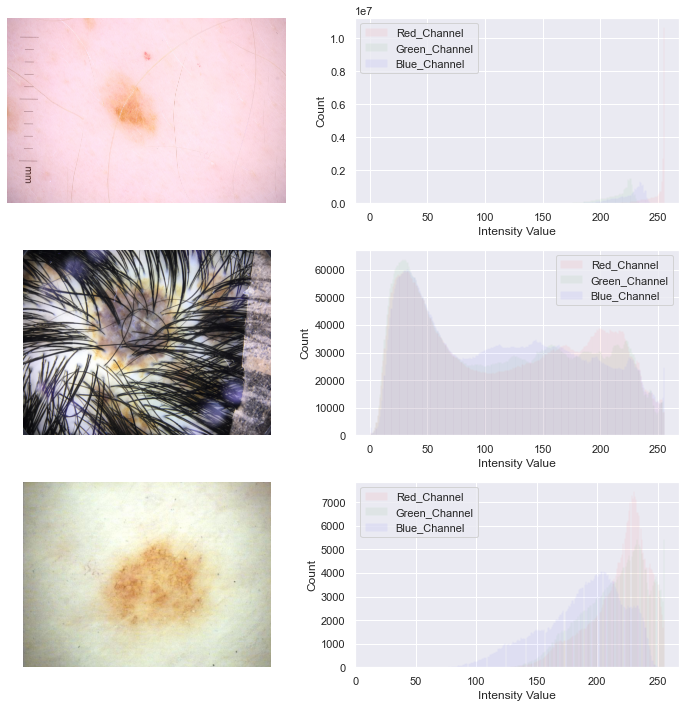

In [41]:
ListImages_Benign = df_md_train.loc[df_md_train.benign_malignant == 'benign', 'image_name'].values
PlotRandomImages(ListImages_Benign, input_jpeg_train)

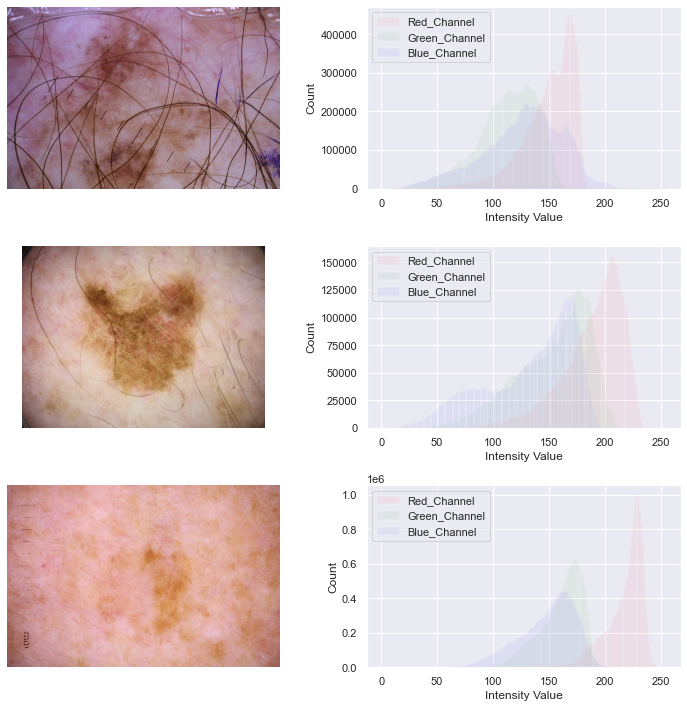

In [42]:
ListImages_Malignant = df_md_train.loc[df_md_train.benign_malignant == 'malignant', 'image_name'].values
PlotRandomImages(ListImages_Malignant, input_jpeg_train)

From the previous analysis, I conclude that:
- There are significant colour differences between Benign / Malignant pictures
- There are a disparity of image sizes - I might need to homogenise

In [67]:
def ExtractFeaturesDICOM(folder):
    ListFiles = os.listdir(folder)
    if not ListFiles:
        print("Folder Empty - Check path...")
        return pd.DataFrame()
    
    df = pd.DataFrame()
    for File in tqdm(ListFiles):
        img = pydicom.dcmread(folder + os.sep + File)
        df = df.append(pd.DataFrame({
            'image_name:': File.split(".")[0],
            'rows': img.Rows,
            'columns': img.Columns}, index=[0]))

    return df
        

In [78]:
df_dicom = ExtractFeaturesDICOM(input_dcm_train)
df_dicom.loc[:, ['rows', 'columns']].value_counts()[0:10] / df_dicom.shape[0] * 100

100%|██████████| 33126/33126 [02:53<00:00, 191.00it/s]


rows  columns
4000  6000       44.385075
1053  1872       22.743464
480   640        12.518867
3456  5184       10.318179
2448  3264        4.476846
2848  4288        2.200688
1936  2592        2.034656
2592  3888        0.422629
3024  4032        0.253577
2317  2317        0.087545
dtype: float64

In [79]:
df_dicom = ExtractFeaturesDICOM(input_dcm_test)
df_dicom.loc[:, ['rows', 'columns']].value_counts()[0:10] / df_dicom.shape[0] * 100

100%|██████████| 10982/10982 [00:50<00:00, 219.13it/s]


rows  columns
4000  6000       37.898379
1053  1872       18.767073
1080  1920       15.625569
480   640        11.145511
3456  5184        6.638135
2448  3264        4.398106
1936  2592        2.413040
2848  4288        1.812056
576   768         0.482608
3024  4032        0.127481
dtype: float64

Hence, all images need to be downsampled to a common resolution. As it is still unclear which resolution would this be (I am still unclear of the implications of this), let's create a generic function that we can use for fine-tunning our result

In [166]:
def TuneImgRes(img, finalRes, verbose=False, plot=False):

    dim = (finalRes[0], finalRes[1])
    img_resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    if verbose:
        print("Initial Image Size", img.shape)
        print("Resized Image", img_resized.shape)

    if plot:
        # Analysis of results of resized    
        plt.subplots(1,2, figsize=(8,5))
        plt.subplot(1,2,1)
        plt.title("Original Image")
        plt.imshow(img)
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(img_resized)
        plt.title("Resized Image")
        plt.axis('off')

Initial Image Size (4000, 6000, 3)
Resized Image (256, 256, 3)


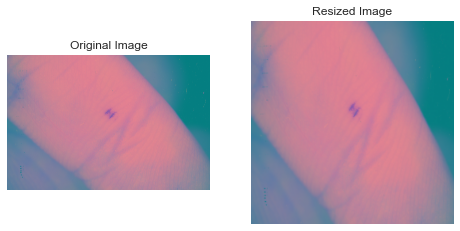

In [167]:
img = pydicom.dcmread(input_dcm_train + os.sep + DCM_FileList[0])
TuneImgRes(img.pixel_array, [256, 256], verbose=True, plot=True)

There is still the problem of the class imbalance - there are a lot more instances of benign melanomas than malignant melanomas. Hence, data augmentation techniques can be explored.
- <b>[Albumentations Image Augmentations](https://albumentations.ai/)</b>: Try different image augmentation strategies provided in this library, such as rotation, RGB shift, etc...
- <b>Body Hair Augmentation</b>: Add fake hair to images (as specified in [Image Augmentation Paper](https://arxiv.org/pdf/1809.02568.pdf) + [Kaggle Discussion](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/159176))
- <b>Microscope Augmentation</b>: Add "microscope filter" to the images (as discussed in [Kaggle Discussion](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/159476))
- <b>Random Erasing Augmentation</b>: Randomly select a rectangle region in an image and erases its pixels with random noise (as specified in [Image Augmentation Paper](https://arxiv.org/pdf/1809.02568.pdf))

I will start by creating a sample code that performs these augmentations, which can be adapted later on down the pipeline

In [168]:
# Adapted from -> https://www.kaggle.com/nxrprime/siim-d3-eda-augmentations-and-resnext?scriptVersionId=39367937
def AugmentImg(img):

    # Create Augmentation List
    albumentation_list = [A.RandomSunFlare(p=0.8), A.GaussNoise(p=0.8), A.CLAHE(p=0.9),
                      A.RandomRain(p=1), A.Rotate(p=1, limit=90),
                      A.RGBShift(p=1), A.RandomSnow(p=1),
                      A.HorizontalFlip(p=1), A.VerticalFlip(p=0.8), A.RandomContrast(limit = 0.5,p = 1),
                      A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50)]

    aug_img_list = []
    aug_img_list.append(img)
    for aug_type in albumentation_list:
        aug_img = aug_type(image = img)['image']
        aug_img_list.append(aug_img)

    titles_list = ["Original","RandomSunFlare","GaussNoise","CLAHE",
               "RandomRain","Rotate", "RGBShift", "RandomSnow","HorizontalFlip", "VerticalFlip", "RandomContrast","HSV"]

    fig, axs = plt.subplots(3,4,figsize=(20, 15))
    fig.suptitle("Different Types of Augmentations", fontsize = 30)

    for idx in range(12):
        plt.subplot(3,4, idx+1)
        plt.imshow(aug_img_list[idx])
        plt.title(titles_list[idx])
        plt.axis('off')
    plt.show()


/Users/miguelcachosoblechero/opt/anaconda3/envs/SpringBoard/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1770: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


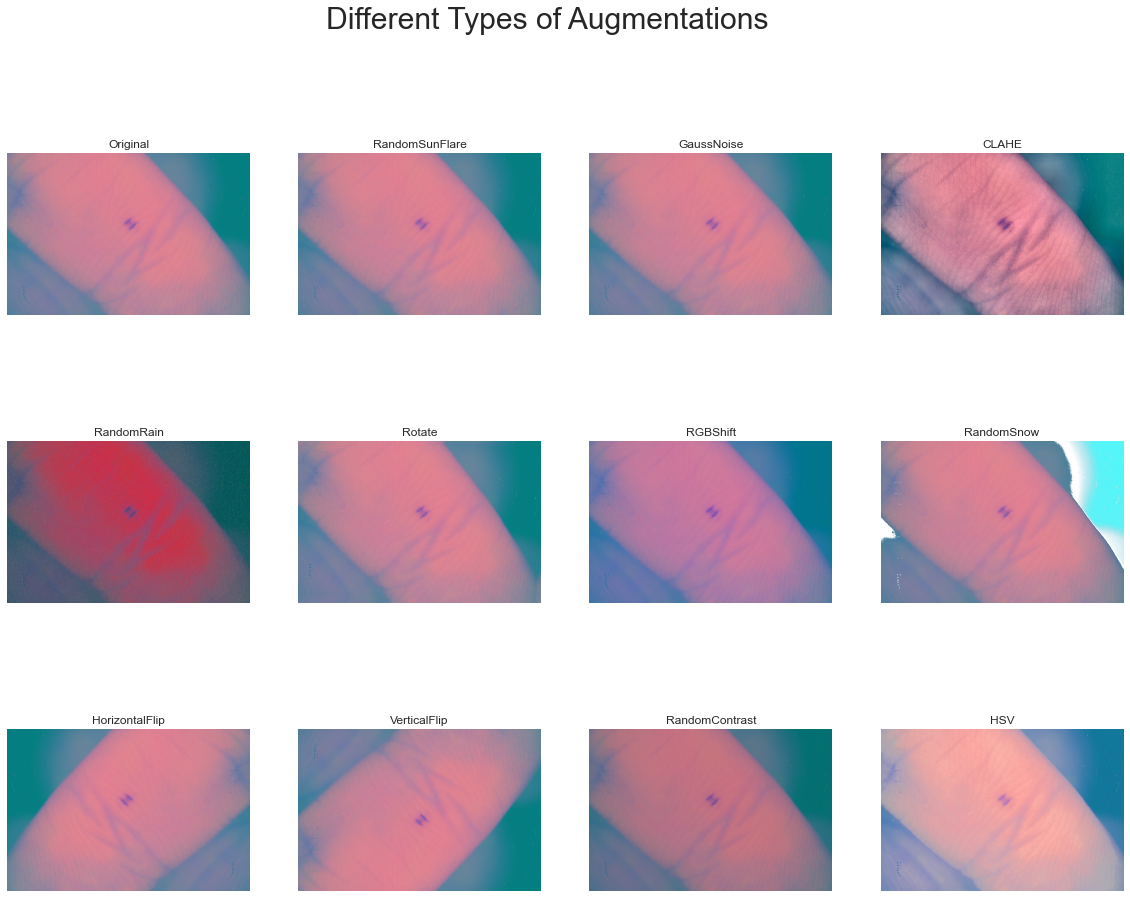

In [169]:
img = pydicom.dcmread(input_dcm_train + os.sep + DCM_FileList[0])
AugmentImg(img.pixel_array)

In [170]:
def AugmentImg_Microscope(img):
    center = (img.shape[1]//2, img.shape[0]//2)
    radious = random.randint(img.shape[0]//2 - 3, img.shape[0]//2 + 15)    
    circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8),
            center,
            radious,
            (0, 0, 0),
            -1)

    mask = circle - 255
    aug_img = np.multiply(img, mask)
    
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    plt.suptitle("Microscope Effect - Image Augmentation")
    
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(aug_img)
    plt.title("Microscope Effect")
    plt.axis('off')
    

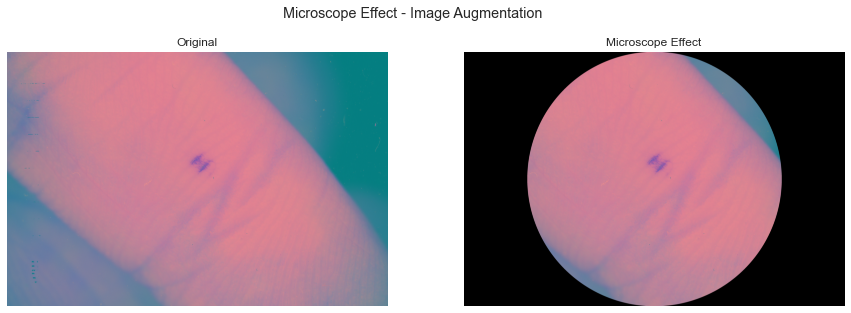

In [171]:
img = pydicom.dcmread(input_dcm_train + os.sep + DCM_FileList[0])
AugmentImg_Microscope(img.pixel_array)

In [172]:
# Adapted from -> https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/159176 
def AugmentImg_Hair(img, n_hairs, folder_hair, reshape=False):

    if not n_hairs:
        return img

    if reshape:
        img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)

    height, width, _ = img.shape                                                    # Target image width and height
    hair_images = [im for im in os.listdir(folder_hair) if 'png' in im]             # Obtain list of hair images
    aug_img = img.copy()                                                            # Copy the original image for comparison

    for _ in range(n_hairs):
        hair = cv2.imread(os.path.join(folder_hair, random.choice(hair_images)))    # Select a random hair image
        hair = cv2.flip(hair, random.choice([-1, 0, 1]))                            # Select random V/H rotation 
        hair = cv2.rotate(hair, random.choice([0, 1, 2]))                           # Select random rotation 

        h_height, h_width, _ = hair.shape
        roi_ho = random.randint(0, aug_img.shape[0] - hair.shape[0])                    # Select random position for the image - Height
        roi_wo = random.randint(0, aug_img.shape[1] - hair.shape[1])                    # Select random position for the image - Width
        roi = aug_img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

        img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
        ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
        mask_inv = cv2.bitwise_not(mask)
        img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
        hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

        dst = cv2.add(img_bg, hair_fg)
        aug_img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst

    fig, ax = plt.subplots(1,2,figsize=(15,5))
    plt.suptitle("Hair Effect - Image Augmentation")
    
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(aug_img)
    plt.title("Hair Effect")
    plt.axis('off')

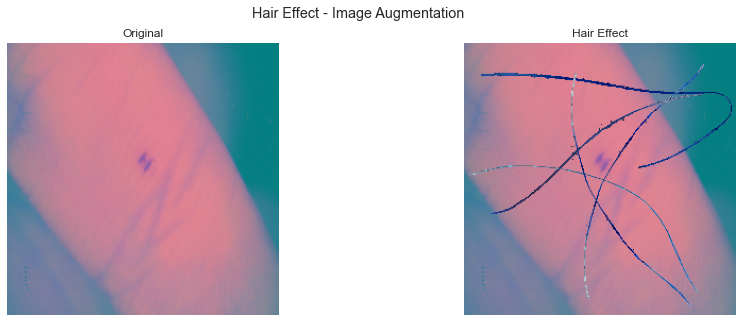

In [173]:
hair_folder =  "resources/Hair/"
img = pydicom.dcmread(input_dcm_train + os.sep + DCM_FileList[0])

AugmentImg_Hair(img.pixel_array, 5, hair_folder, reshape=True)


Additionally, I can potentially download additional data that could be used for improving the accuracy from [here](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/169139)